In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations
import pandas as pd
from pathlib import Path
import numpy as np
import json
# pd.set_option('display.max_rows', 500)

# Get similarities between plinder-v0 train and test
here we use leakage data from
- gs://plinder-collab-bucket/2024-04/v1/leakage

In [2]:
metrics_dict = {
    'pocket_qcov': 'POCKET SHARED', 
    'pocket_lddt': 'POCKET LDDT',
    'protein_lddt_qcov_weighted_sum': 'PROTEIN LDDT',
    'protein_seqsim_weighted_sum': 'PROTEIN SEQSIM',
    'pli_qcov': 'PLI SHARED',
    'tanimoto_similarity_max': 'LIGAND SIMILARITY',
}
metrics_dict.keys()


dict_keys(['pocket_qcov', 'pocket_lddt', 'protein_lddt_qcov_weighted_sum', 'protein_seqsim_weighted_sum', 'pli_qcov', 'tanimoto_similarity_max'])

In [3]:
# directly from bucket
output_maxsim_dir = 'gs://plinder-collab-bucket/2024-04/v1/leakage'

In [4]:
# get the right split
datasplit = 'plinder-v0'
test_split_file = 'gs://plinder-collab-bucket/2024-04/v1/splits/v0/splits/plinder_split_v0.parquet'
# datasplit = 'splits_metaflow_config_split_batch_6_9_yaml_e9ca06e682c3cb2f9340542d1ec1f6dc'
# test_split_file = 'gs://plinder-collab-bucket/2024-04/v1/splits/batch_6/splits_metaflow_config_split_batch_6_9_yaml_e9ca06e682c3cb2f9340542d1ec1f6dc.parquet'
# datasplit = 'splits_metaflow_config_split_batch_6_2_yaml_ff5ef415b01555aeb2bdef1f1d52a44e'
# test_split_file = 'gs://plinder-collab-bucket/2024-04/v1/splits/batch_6/splits_metaflow_config_split_batch_6_2_yaml_ff5ef415b01555aeb2bdef1f1d52a44e.parquet'
df_v0 = pd.read_parquet(test_split_file)
test_v0 = df_v0[df_v0.split == 'test'].system_id.to_list()
df_test = pd.DataFrame([{'system_id': t} for t in test_v0])

In [5]:
dfs_maxsim = []
for metric in metrics_dict.keys():
    for ds in [datasplit]:
        filename = f'{ds}__{metric}__train_test.parquet'
        df_maxsim = pd.read_parquet(f'{output_maxsim_dir}/{filename}')
        df_maxsim['metric'] =  metric
        df_maxsim['datasplit'] =  ds.replace("-", "_").lower()
        df_maxsim['inference_set'] = "test"
        # df_maxsim["similarity"] /= 100
        df_maxsim.rename(columns={"query_system": "system_id"}, inplace=True)
        df_maxsim = df_maxsim[df_maxsim['system_id'].isin(test_v0)]
        # df_maxsim['system_id'] = df_maxsim['system_id'].apply(lambda x: x.lower().split('_')[0])
        print(filename, df_maxsim.shape[0])
        dfs_maxsim.append(df_maxsim)
dfs_maxsim = pd.concat(dfs_maxsim)
print(len(dfs_maxsim))
dfs_maxsim = dfs_maxsim.sort_values('similarity', ascending=False).groupby(['system_id', 'datasplit', 'inference_set', 'metric']).agg('first').reset_index()
print(len(dfs_maxsim))
dfs_maxsim.head()

plinder-v0__pocket_qcov__train_test.parquet 699
plinder-v0__pocket_lddt__train_test.parquet 196
plinder-v0__protein_lddt_qcov_weighted_sum__train_test.parquet 157
plinder-v0__protein_seqsim_weighted_sum__train_test.parquet 1386
plinder-v0__pli_qcov__train_test.parquet 430
plinder-v0__tanimoto_similarity_max__train_test.parquet 5125
7993
5092


,system_id,datasplit,inference_set,metric,similarity
0,1a4i__1__1.A__1.C,plinder_v0,test,tanimoto_similarity_max,100
1,1aqb__1__1.A__1.C,plinder_v0,test,tanimoto_similarity_max,100
2,1auk__1__6.A__6.B,plinder_v0,test,pocket_lddt,33
3,1auk__1__6.A__6.B,plinder_v0,test,protein_lddt_qcov_weighted_sum,45
4,1auk__1__6.A__6.B,plinder_v0,test,protein_seqsim_weighted_sum,45


## Good test systems

Splitting should support 3 use cases, at minimum, while ensuring no leakage occurring 
- Blind docking: Pocket not known

- Virtual screening: Pocket known, but often no known related binders to pocket 

- Lead optimization: Pocket known & existing members of series known 


-- Pocket aware ligand generation (this is a task attempted by some methods like DiffSBDD) - it is one of the ultimate goals for this field, too, thus – we should consider that – it also intuitively adds more emphasis to deleaking the ligand similarities. 

In [6]:
dfs = dfs_maxsim[['system_id', 'metric', 'similarity']].pivot(index='system_id', columns='metric')
dfs.columns = dfs.columns.get_level_values(1)
dfs = dfs.reset_index()
# merge with all the test - in case of no leakage systems
dfs = pd.merge(df_test, dfs, on='system_id', how='left').fillna(0)
dfs.head()

,system_id,pli_qcov,pocket_lddt,pocket_qcov,protein_lddt_qcov_weighted_sum,protein_seqsim_weighted_sum,tanimoto_similarity_max
0,6un0__1__1.A__1.B,83.0,0.0,88.0,0.0,100.0,0.0
1,6umy__1__1.A__1.B,75.0,0.0,88.0,0.0,100.0,100.0
2,2bt9__1__1.C__1.H,0.0,0.0,0.0,0.0,0.0,54.0
3,7spx__1__1.A__1.B,67.0,0.0,72.0,0.0,99.0,100.0
4,8jea__2__1.B__1.E,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
len(dfs)

3758

In [8]:
# tanimoto_similarity_max
# pocket_lddt
# protein_lddt_qcov_weighted_sum
# protein_seqsim_weighted_sum
# pocket_qcov
# pli_qcov

In [9]:
dfs['test_rigiddock'] = np.logical_and.reduce([
    dfs.pli_qcov < 50,
    dfs.pocket_lddt < 50,
    dfs.pocket_qcov < 50,
    # dfs.protein_seqsim_weighted_sum < 30,
    # dfs.protein_lddt_qcov_weighted_sum < 70,
    # dfs.tanimoto_similarity_max < 30
])

dfs['test_cofold'] = np.logical_and.reduce([
    dfs.pli_qcov < 50,
    dfs.pocket_lddt < 50,
    dfs.pocket_qcov < 50,
    dfs.protein_seqsim_weighted_sum < 30,
    dfs.protein_lddt_qcov_weighted_sum < 70,
    # dfs.tanimoto_similarity_max < 30
])

dfs['test_liggen'] = np.logical_and.reduce([
    dfs.pli_qcov < 50,
    dfs.pocket_lddt < 50,
    dfs.pocket_qcov < 50,
    # dfs.protein_seqsim_weighted_sum < 30,
    # dfs.protein_lddt_qcov_weighted_sum < 70,
    dfs.tanimoto_similarity_max < 30
])

dfs['test_superstrict'] = np.logical_and.reduce([
    dfs.pli_qcov < 50,
    dfs.pocket_lddt < 50,
    dfs.pocket_qcov < 50,
    dfs.protein_seqsim_weighted_sum < 30,
    dfs.protein_lddt_qcov_weighted_sum < 70,
    dfs.tanimoto_similarity_max < 30
])

In [10]:
dfs.groupby('test_rigiddock').system_id.count()

test_rigiddock
False     349
True     3409
Name: system_id, dtype: int64

In [11]:
dfs.groupby('test_cofold').system_id.count()

test_cofold
False    1368
True     2390
Name: system_id, dtype: int64

In [12]:
dfs.groupby('test_liggen').system_id.count()

test_liggen
False    2284
True     1474
Name: system_id, dtype: int64

In [13]:
dfs.groupby('test_superstrict').system_id.count()

test_superstrict
False    2745
True     1013
Name: system_id, dtype: int64

In [14]:
dfs

,system_id,pli_qcov,pocket_lddt,pocket_qcov,protein_lddt_qcov_weighted_sum,protein_seqsim_weighted_sum,tanimoto_similarity_max,test_rigiddock,test_cofold,test_liggen,test_superstrict
0,6un0__1__1.A__1.B,83.0,0.0,88.0,0.0,100.0,0.0,False,False,False,False
1,6umy__1__1.A__1.B,75.0,0.0,88.0,0.0,100.0,100.0,False,False,False,False
2,2bt9__1__1.C__1.H,0.0,0.0,0.0,0.0,0.0,54.0,True,True,False,False
3,7spx__1__1.A__1.B,67.0,0.0,72.0,0.0,99.0,100.0,False,False,False,False
4,8jea__2__1.B__1.E,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
3753,5m7j__1__1.A__1.E,0.0,0.0,0.0,0.0,0.0,100.0,True,True,False,False
3754,5xt6__1__1.B_1.C__1.G,50.0,0.0,37.0,0.0,51.0,100.0,False,False,False,False
3755,8f3s__1__1.A__1.B,0.0,0.0,27.0,0.0,51.0,100.0,True,False,False,False
3756,6z06__1__1.C__1.E,0.0,0.0,0.0,0.0,99.0,0.0,True,False,True,False


<Axes: >

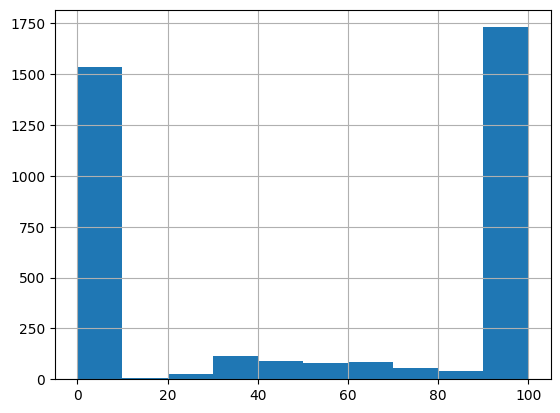

In [15]:
dfs['tanimoto_similarity_max'].hist()

In [16]:
dfs[
    np.logical_and.reduce([
        ~dfs.test_superstrict,
        ~dfs.test_cofold,
        ~dfs.test_rigiddock,
        ~dfs.test_liggen,
    ])
]

,system_id,pli_qcov,pocket_lddt,pocket_qcov,protein_lddt_qcov_weighted_sum,protein_seqsim_weighted_sum,tanimoto_similarity_max,test_rigiddock,test_cofold,test_liggen,test_superstrict
0,6un0__1__1.A__1.B,83.0,0.0,88.0,0.0,100.0,0.0,False,False,False,False
1,6umy__1__1.A__1.B,75.0,0.0,88.0,0.0,100.0,100.0,False,False,False,False
3,7spx__1__1.A__1.B,67.0,0.0,72.0,0.0,99.0,100.0,False,False,False,False
7,2ewk__1__1.A__1.C,71.0,0.0,93.0,0.0,60.0,0.0,False,False,False,False
8,2ewi__1__1.A__1.C,71.0,0.0,93.0,0.0,50.0,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
3717,6zhi__2__1.A__1.E,43.0,0.0,88.0,0.0,70.0,63.0,False,False,False,False
3720,6ok2__1__1.A__1.G,80.0,0.0,43.0,0.0,100.0,100.0,False,False,False,False
3742,4our__1__1.A__1.K,55.0,0.0,74.0,0.0,54.0,0.0,False,False,False,False
3746,4zki__1__1.B__1.C,33.0,0.0,50.0,0.0,100.0,100.0,False,False,False,False


## Sanity check for superstrict samples still including some MMS count and non oligo ligands

In [17]:
mms_df = pd.read_parquet("gs://plinder-collab-bucket/2024-04/v1/mmp/plinder_mmp_series.parquet")
mms_df.head(3)

,system_id,congeneric_id,CONSTANT,prot_pocket_set_shared,congeneric_series,mms_unique_count,const_size,congeneric_ligand_ccd_code
0,10mh__1__1.C__1.D,c5518,[*:1]C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[...,c1458_c1386,"[SAH, SAM]",2.0,18.0,SAH
1,10mh__1__1.C__1.D,c13146,[*:1][C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C...,c1458_c1386,"[SAH, SAM]",2.0,17.0,SAH
2,11gs__1__1.A_1.B__1.C_1.D,c5249,[*:1]C[C@H](NC(=O)CC[C@H](N)C(=O)O)C(=O)NCC(=O)O,c0_c55,"[GSH, GTS, IBG]",3.0,19.0,GSH


<Axes: >

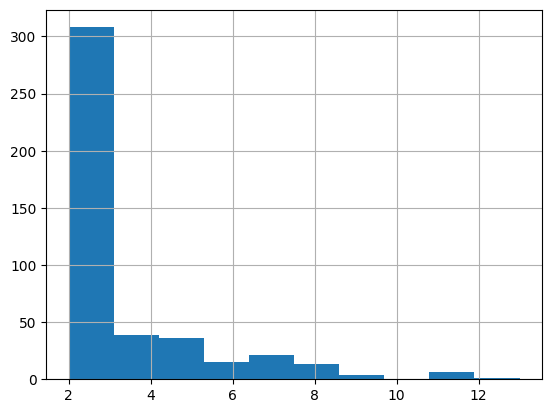

In [18]:
pd.merge(dfs[dfs.test_superstrict], mms_df, on='system_id', how='inner').mms_unique_count.hist()

In [19]:
annotation_table = 'gs://plinder-collab-bucket/2024-04/v1/index/annotation_table.parquet'
# annotation_table = 'gs://plinder-collab-bucket/2024-04/v1/index/annotation_table_nonredundant.parquet'
df_table = pd.read_parquet(annotation_table)
df_table

,entry_pdb_id,entry_release_date,entry_oligomeric_state,entry_determination_method,entry_keywords,entry_pH,entry_resolution,entry_rfree,entry_r,entry_clashscore,...,ligand_interacting_ligand_chains_Pfam,ligand_neighboring_ligand_chains_Pfam,ligand_interacting_ligand_chains_PANTHER,ligand_neighboring_ligand_chains_PANTHER,system_ligand_chains_SCOP2,system_ligand_chains_SCOP2B,protein_lddt_qcov_weighted_sum__100__strong__component,pli_qcov__100__strong__component,system_ccd_codes,uniqueness
0,3grt,1997-02-12,dimeric,X-RAY DIFFRACTION,OXIDOREDUCTASE,8.0,2.50,NaN,0.1700,12.90,...,None,None,None,None,None,None,c34240,c12264,FAD,3grt_c34240_c12264_FAD
1,3grt,1997-02-12,dimeric,X-RAY DIFFRACTION,OXIDOREDUCTASE,8.0,2.50,NaN,0.1700,12.90,...,None,None,None,None,None,None,c597,c119031,TS2,3grt_c597_c119031_TS2
2,3grt,1997-02-12,dimeric,X-RAY DIFFRACTION,OXIDOREDUCTASE,8.0,2.50,NaN,0.1700,12.90,...,None,None,None,None,None,None,c34240,c12264,FAD,3grt_c34240_c12264_FAD
3,3grt,1997-02-12,dimeric,X-RAY DIFFRACTION,OXIDOREDUCTASE,8.0,2.50,NaN,0.1700,12.90,...,None,None,None,None,None,None,c597,c50016,TS2,3grt_c597_c50016_TS2
4,1grx,1993-10-01,monomeric,SOLUTION NMR,ELECTRON TRANSPORT,None,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,c116550,c55277,GSH,1grx_c116550_c55277_GSH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726139,4lpn,2013-07-16,24-meric,X-RAY DIFFRACTION,OXIDOREDUCTASE,9,1.66,0.1768,0.1586,3.34,...,None,None,None,None,None,None,None,None,MG,None
1726140,2lp3,2012-01-31,dimeric,SOLUTION NMR,METAL BINDING PROTEIN,None,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,CA,None
1726141,2lp3,2012-01-31,dimeric,SOLUTION NMR,METAL BINDING PROTEIN,None,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,CA,None
1726142,2lp3,2012-01-31,dimeric,SOLUTION NMR,METAL BINDING PROTEIN,None,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,CA,None


In [20]:
dfs_tab = pd.merge(dfs, df_table, on='system_id', how='left')

In [21]:
dfs_tab[dfs_tab.test_superstrict].groupby('ligand_is_lipinski').count()['system_id']

ligand_is_lipinski
False    483
True     530
Name: system_id, dtype: int64

In [22]:
dfs_tab[dfs_tab.test_superstrict].groupby('ligand_is_oligo').count()['system_id']

ligand_is_oligo
False    794
True     219
Name: system_id, dtype: int64

In [23]:
# [col for col in df_table.columns if col.lower().find('heavy_atom') != -1]

<Axes: >

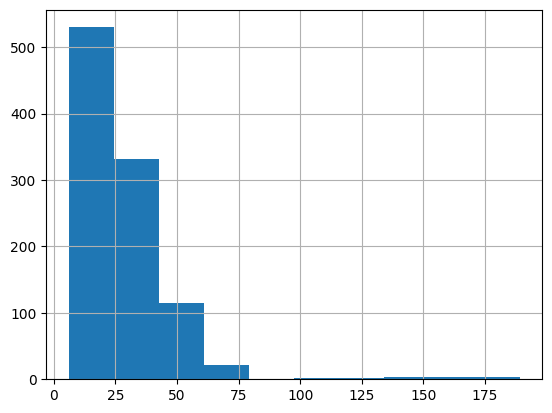

In [24]:
dfs_tab[dfs_tab.test_superstrict].ligand_num_heavy_atoms.hist()